<a href="https://colab.research.google.com/github/JerryChenz/Screener_Proc_v1/blob/master/Screener.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initiation

In [5]:
import pandas as pd
from IPython.display import display

def screen_companies(df):
    """
    Screen companies based on a combined ranking using three financial metrics:
    1. EBIT/Market Cap (higher is better)
    2. ROIC (higher is better)
    3. Composite indicator of Dividend per share/Price and Total Debt/Common Equity
    """
    # Calculate EBIT
    df['EBIT'] = df['Past Annual Sales'] - df['Past Annual Cogs'] - df['Past Annual Opex']

    # Calculate financial metrics
    df['EBIT/Market Cap'] = df['EBIT'] / df['Market Cap']
    df['ROIC'] = df['EBIT'] / df['Latest Invested Capital']
    df['D/P'] = df['Past Financial Year Dividends'] / df['Market Price']
    df['Total Debt/Common Equity'] = df['Latest Total Debt'] / df['Latest Common Equity']

    # Filter valid rows
    valid_mask = (
        (df['Market Price'] > 0) &
        (df['Market Cap'] > 0) &
        (df['Latest Invested Capital'] > 0) &
        (df['EBIT'].notna()) &
        (df['Past Financial Year Dividends'].notna()) &
        (df['Latest Common Equity'].notna()) &
        (df['Latest Total Debt'].notna())
    )
    df_valid = df[valid_mask].copy()

    if df_valid.empty:
        print("No valid data remaining after filtering.")
        return pd.DataFrame(columns=[
            'Ticker', 'Company Name', 'Industry', 'Market Price', 'Market Cap', 'Market Currency',
            'EBIT/Market Cap', 'ROIC', 'D/P', 'Total Debt/Common Equity', 'Combined_rank'
        ])

    # Identify companies with positive common equity
    df_valid['positive_equity'] = df_valid['Latest Common Equity'] > 0

    # Rank individual metrics
    df_valid['EBIT/Market Cap_rank'] = df_valid['EBIT/Market Cap'].rank(ascending=False, method='min')
    df_valid['ROIC_rank'] = df_valid['ROIC'].rank(ascending=False, method='min')
    df_valid['D/P_rank'] = df_valid['D/P'].rank(ascending=False, method='min')

    # Rank Total Debt/Common Equity, handling negative/zero equity
    M = df_valid['positive_equity'].sum()
    df_valid.loc[df_valid['positive_equity'], 'Total Debt/Common Equity_rank'] = (
        df_valid.loc[df_valid['positive_equity'], 'Total Debt/Common Equity'].rank(ascending=True, method='min')
    )
    sub_rank = df_valid.loc[~df_valid['positive_equity'], 'Latest Total Debt'].rank(ascending=True, method='min')
    df_valid.loc[~df_valid['positive_equity'], 'Total Debt/Common Equity_rank'] = M + sub_rank

    # Calculate composite indicator
    df_valid['composite_score'] = df_valid['D/P_rank'] + df_valid['Total Debt/Common Equity_rank']
    df_valid['composite_rank'] = df_valid['composite_score'].rank(ascending=True, method='min')

    # Calculate combined rank
    df_valid['Combined_rank'] = (
        df_valid['EBIT/Market Cap_rank'] +
        df_valid['ROIC_rank'] +
        df_valid['composite_rank']
    )

    # Sort by combined rank
    df_sorted = df_valid.sort_values('Combined_rank')

    # Select output columns
    output_columns = [
        'Ticker', 'Company Name', 'Industry', 'Market Price', 'Market Cap', 'Market Currency',
        'EBIT/Market Cap', 'ROIC', 'D/P', 'Total Debt/Common Equity', 'Combined_rank'
    ]
    df_output = df_sorted[output_columns]

    return df_output

def display_formatted_screen(df_output):
    """
    Display the output dataframe from screen_companies with formatted values:
    - Market Price rounded to 2 decimal places
    - Market Cap in millions, rounded to 2 decimal places
    - Four indicators (EBIT/Market Cap, ROIC, D/P, Total Debt/Common Equity) as percentages rounded to 2 decimal places
    """
    from IPython.display import display

    if df_output.empty:
        display(df_output)
        return

    df_display = df_output.copy()

    # Format Market Price
    df_display['Market Price'] = df_display['Market Price'].round(2)

    # Format Market Cap to millions
    df_display['Market Cap'] = (df_display['Market Cap'] / 1000000).round(2)

    # Format indicators to percentages
    indicators = ['EBIT/Market Cap', 'ROIC', 'D/P', 'Total Debt/Common Equity']
    for indicator in indicators:
        df_display[indicator] = (df_display[indicator] * 100).round(2)

    # Display the formatted dataframe
    display(df_display)

In [6]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

def create_financial_metric_histogram(df, column_name, metric_name):
    """
    Creates a histogram for a financial metric with outlier handling and proper formatting.

    Args:
        df: Pandas DataFrame containing the data
        column_name: Name of the column to plot
        metric_name: Name of the metric for labeling
    """
    # Calculate IQR for outlier detection
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = max(0, q1 - 1.5 * iqr)  # Ensure non-negative values
    upper_bound = q3 + 1.5 * iqr

    # Filter data to exclude outliers
    filtered_data = df[
        (df[column_name] >= lower_bound) &
        (df[column_name] <= upper_bound)
    ]

    # Create histogram
    plt.figure(figsize=(10, 6))
    filtered_data[column_name].plot(
        kind='hist',
        bins=20,
        title=f'{metric_name} Distribution',
        edgecolor='black'
    )

    # Format axes
    plt.ylabel('Number of Stocks')
    plt.gca().xaxis.set_major_formatter(
        FuncFormatter(lambda x, pos: f"{x * 100:.2f}%")
    )
    plt.xlim(left=lower_bound, right=upper_bound)

    # Style adjustments
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.show()



# US Stock Screener

In [3]:
us_data = 'https://github.com/JerryChenz/Screener_Proc_v1/blob/master/data/cleaned_data/us_screen_data.csv?raw=true'
hk_data = 'https://github.com/JerryChenz/Screener_Proc_v1/blob/master/data/cleaned_data/hk_screen_data.csv?raw=true'

region = 'us'

try:
    df = pd.read_csv(us_data)
    df_screened = screen_companies(df)
    if not df_screened.empty:
        print(f"Top 100 screened companies:")
        display_formatted_screen(df_screened.head(100))
    else:
        print(f"No screened companies for {region}.")
except Exception as e:
    print(f"Error processing the data for {region}: {e}")

Top 100 screened companies:


,Ticker,Company Name,Industry,Market Price,Market Cap,Market Currency,EBIT/Market Cap,ROIC,D/P,Total Debt/Common Equity,Combined_rank
2766,KSPI,Joint Stock Company Kaspi.kz -,Software - Infrastructure,84.92,16667.59,USD,7625.94,73.10,3002.83,14.60,85.0
5403,YRD,Yiren Digital Ltd.,Credit Services,5.98,519.87,USD,499.12,32.09,53.71,0.29,236.0
2677,KARO,Karooooo Ltd.,Software - Application,40.47,1300.08,USD,80.19,34.36,48.30,9.01,311.0
2301,HMY,Harmony Gold Mining Company Lim,Gold,17.01,10744.66,USD,107.22,27.07,18.87,5.64,396.0
3982,PSIG,PS International Group Ltd.,Integrated Freight & Logistics,0.42,10.44,USD,57.55,46.96,0.00,0.51,438.0
...,...,...,...,...,...,...,...,...,...,...,...
3309,NAT,Nordic American Tankers Limited,Oil & Gas Midstream,2.46,520.91,USD,24.55,15.23,13.82,56.03,1550.0
397,ASTL,Algoma Steel Group Inc.,Steel,4.85,508.57,USD,32.90,10.16,5.94,9.72,1563.0
317,APOG,"Apogee Enterprises, Inc.",Building Products & Equipment,45.61,1024.93,USD,13.06,25.11,2.19,22.55,1564.0
2065,GGB,Gerdau S.A.,Steel,2.57,5149.23,USD,123.20,8.86,31.13,25.74,1565.0


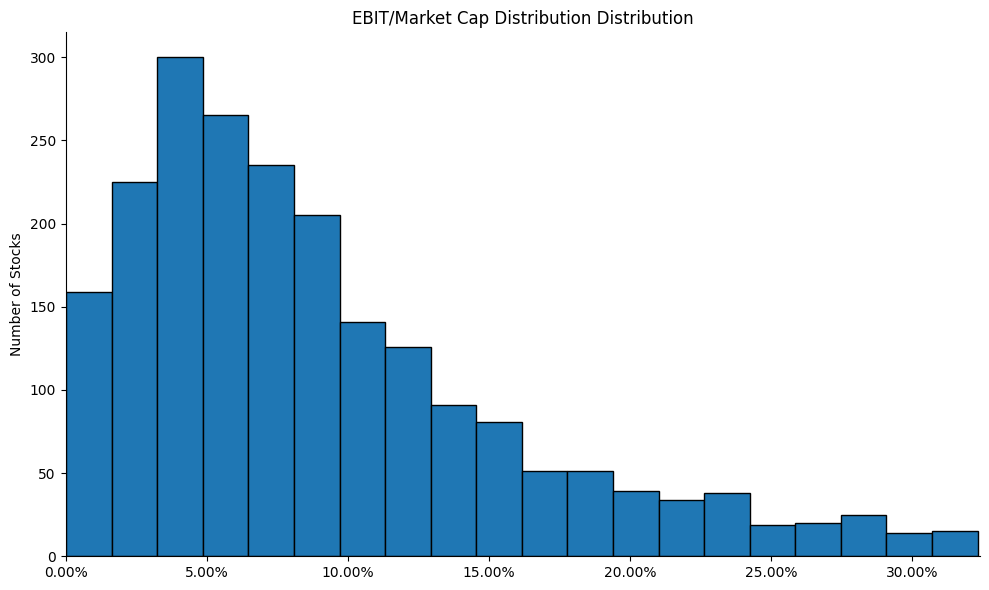

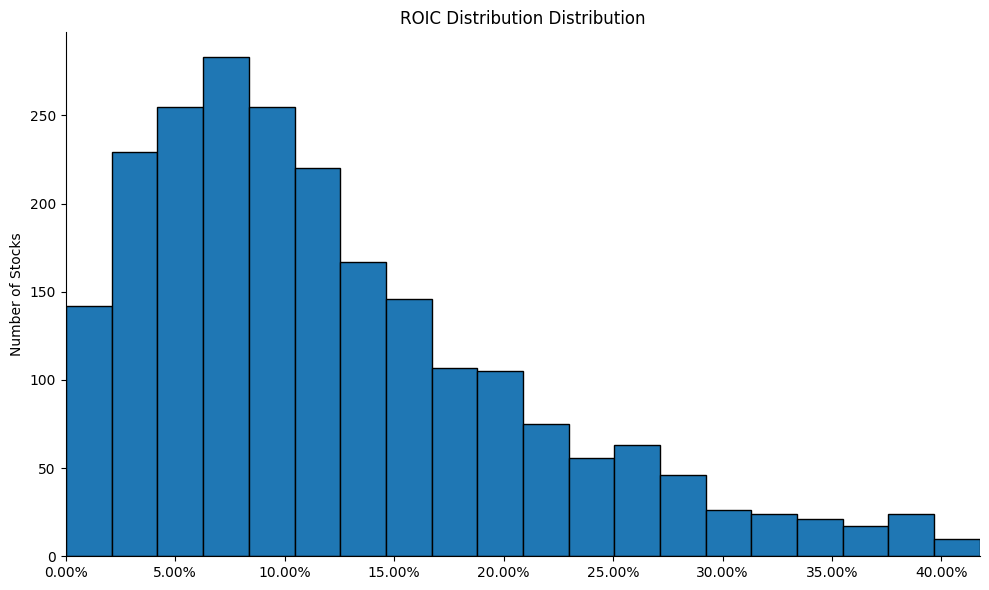

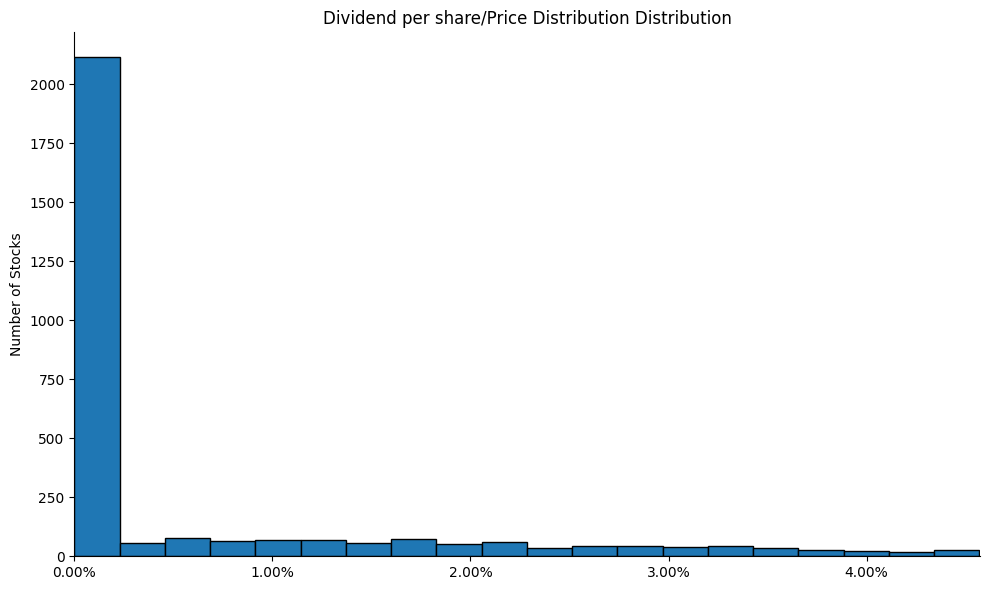

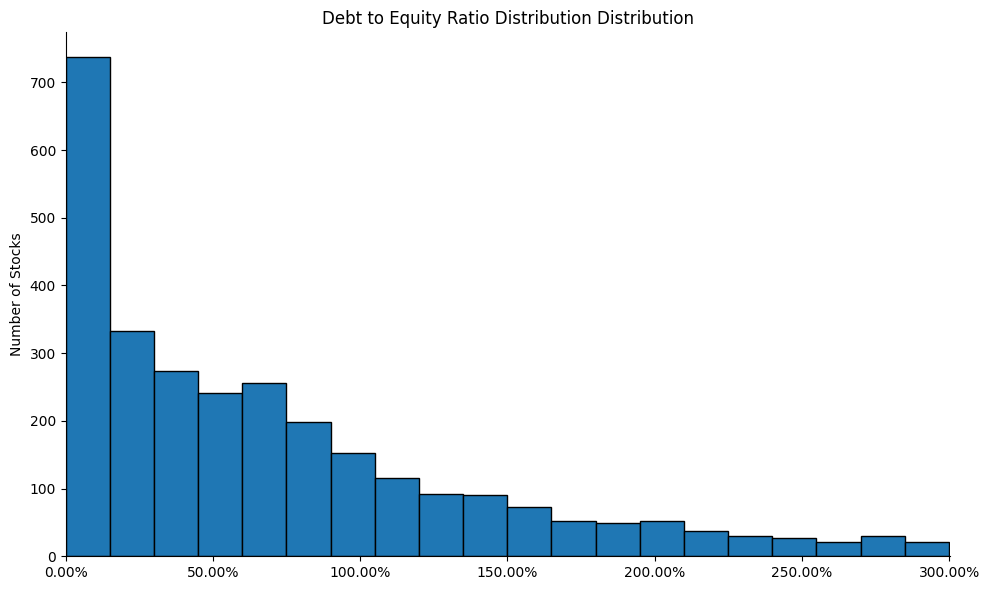

In [7]:
create_financial_metric_histogram(df_screened, 'EBIT/Market Cap', 'EBIT/Market Cap Distribution')
create_financial_metric_histogram(df_screened, 'ROIC', 'ROIC Distribution')
create_financial_metric_histogram(df_screened, 'D/P', 'Dividend per share/Price Distribution')
create_financial_metric_histogram(df_screened, 'Total Debt/Common Equity', 'Debt to Equity Ratio Distribution')

# HK Stock Screener

In [8]:
hk_data = 'https://github.com/JerryChenz/Screener_Proc_v1/blob/master/data/cleaned_data/hk_screen_data.csv?raw=true'

region = 'hk'

try:
    df = pd.read_csv(hk_data)
    hk_df_screened = screen_companies(df)
    if not hk_df_screened.empty:
        print(f"Top 100 screened companies:")
        display_formatted_screen(hk_df_screened.head(100))
    else:
        print(f"No screened companies for {region}.")
except Exception as e:
    print(f"Error processing the data for {region}: {e}")

Top 100 screened companies:


,Ticker,Company Name,Industry,Market Price,Market Cap,Market Currency,EBIT/Market Cap,ROIC,D/P,Total Debt/Common Equity,Combined_rank
1869,2660.HK,ZENGAME,Electronic Gaming & Multimedia,2.18,2250.50,HKD,37.21,36.09,6.47,0.22,323.0
1409,1895.HK,XINYUAN PM,Real Estate Services,0.59,349.89,HKD,40.22,26.13,13.22,2.08,350.0
2631,9983.HK,CC NEW LIFE,Real Estate Services,1.13,1449.77,HKD,38.33,26.37,14.96,3.30,376.0
205,0240.HK,BUILD KING HOLD,Engineering & Construction,1.09,1353.65,HKD,56.41,29.46,9.63,11.96,377.0
1820,2530.HK,NUMANS,Packaged Foods,0.67,670.00,HKD,31.07,50.76,7.46,1.42,377.0
...,...,...,...,...,...,...,...,...,...,...,...
425,0536.HK,TRADELINK,Software - Application,0.93,739.01,HKD,9.71,18.94,10.86,0.40,1024.0
1898,2877.HK,SHINEWAY PHARM,Drug Manufacturers - Specialty & Generic,7.57,5718.38,HKD,17.06,13.30,7.13,4.28,1048.0
90,0104.HK,ASIA COMM HOLD,Specialty Retail,0.21,157.64,HKD,65.45,17.10,16.59,46.26,1051.0
1366,1837.HK,NATURAL FOOD IH,Packaged Foods,0.59,1291.22,HKD,14.37,13.29,6.44,0.41,1054.0


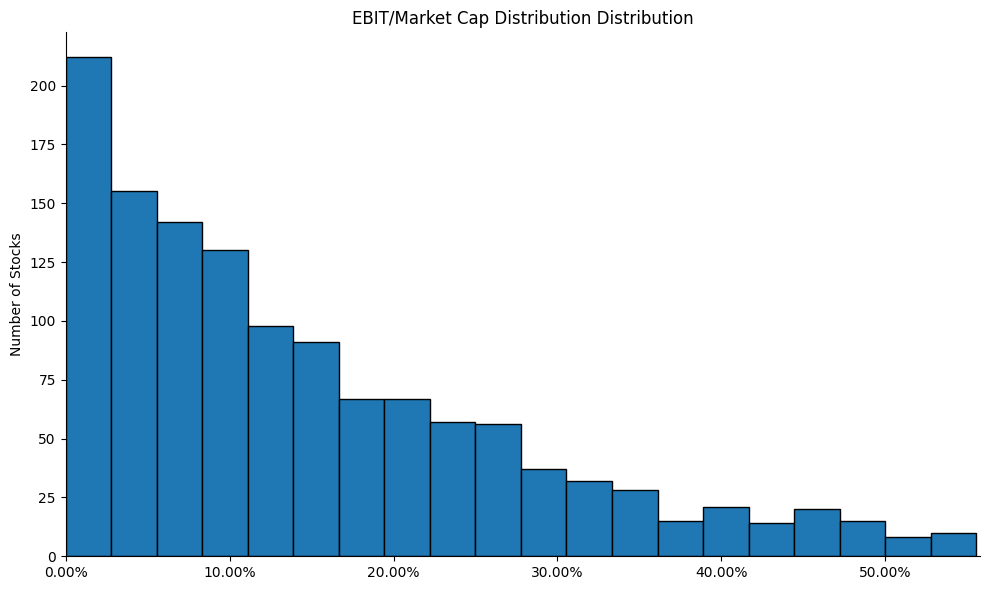

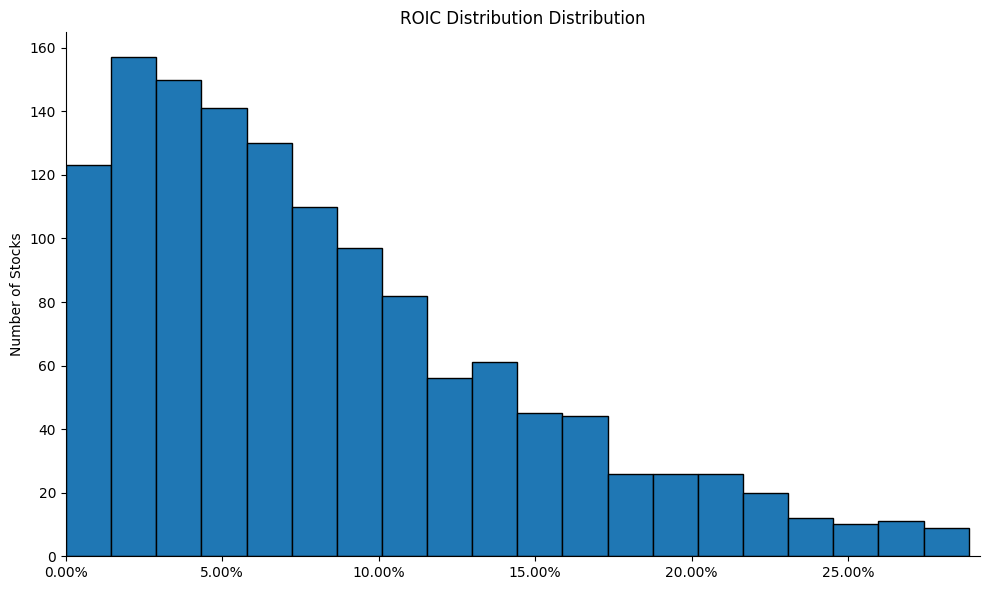

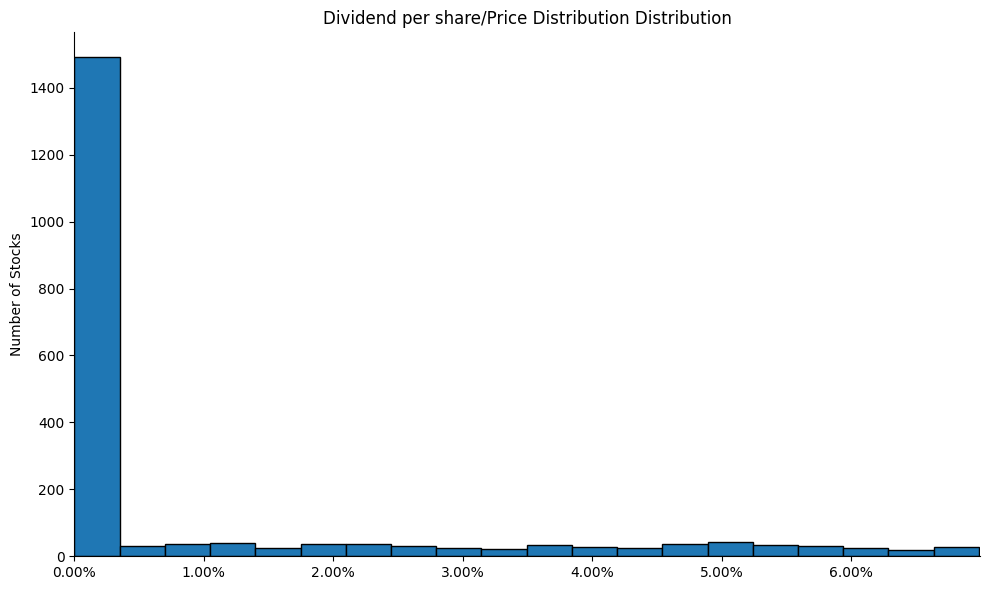

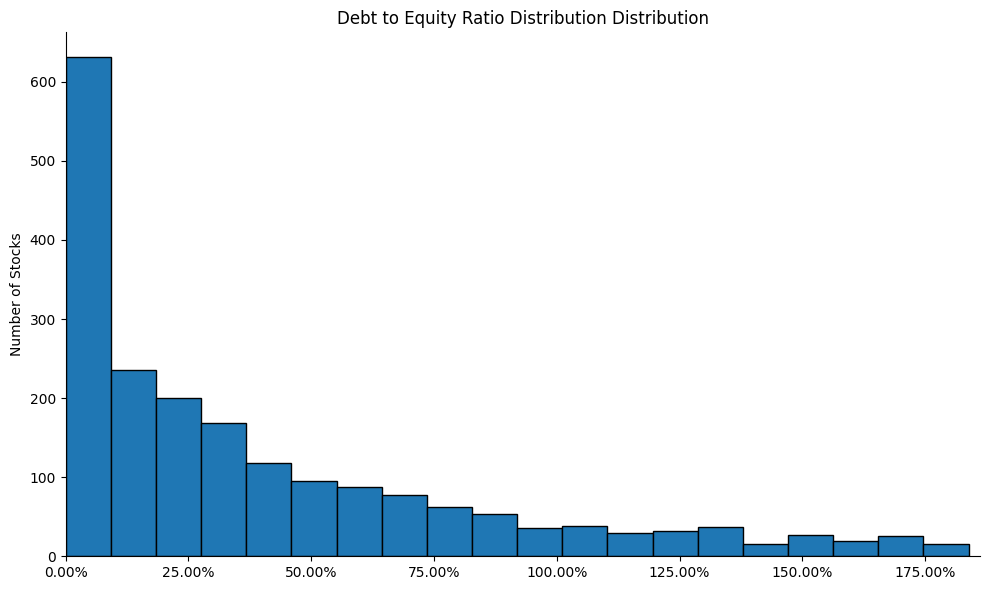

In [9]:
create_financial_metric_histogram(hk_df_screened, 'EBIT/Market Cap', 'EBIT/Market Cap Distribution')
create_financial_metric_histogram(hk_df_screened, 'ROIC', 'ROIC Distribution')
create_financial_metric_histogram(hk_df_screened, 'D/P', 'Dividend per share/Price Distribution')
create_financial_metric_histogram(hk_df_screened, 'Total Debt/Common Equity', 'Debt to Equity Ratio Distribution')

# Download Screeners

In [ ]:
from google.colab import files

if not df_screened.empty:
    csv_filename = f"{region}_screened.csv"
    # df.to_csv(csv_filename, index=False)
    # files.download(csv_filename)
else:
    print(f"No data to download for {region}.")